<a href="https://colab.research.google.com/github/Prasannnnn/Machine-Learning-Projects/blob/AI-and-ML-Projects/Emojify_face_Detect_emotion_ML_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from PIL import Image

from sklearn import metrics

import cv2
import os

from glob import glob

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
data_path = '/content/drive/MyDrive/Colab Notebooks/Emojify---Detect-emotion-from-human-face-ML-Project--main/fer2013.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()
print('The data set has been extracted.')


The data set has been extracted.


In [4]:
path = 'train'
classes = os.listdir('train')
classes

['sad', 'happy', 'neutral', 'fear', 'surprise', 'angry', 'disgust']

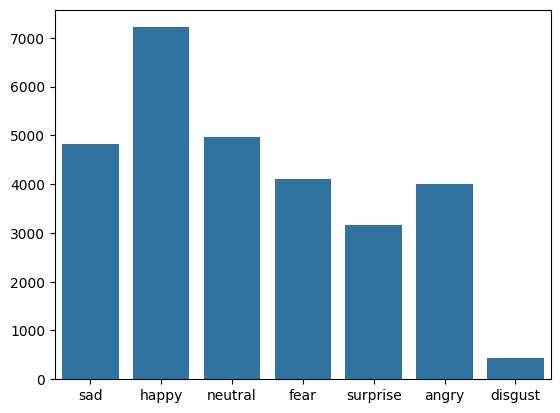

In [5]:
count = []
for cat in classes:
    count.append(len(os.listdir(f'{path}/{cat}')))

sb.barplot(x=classes, y=count)
plt.show()
# Ignore the error in this cell [ERROR :- "count.append(len(os.listdir(f'{path}/{cat}')))"]

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
		'train',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
		'test',
		target_size=(48,48),
		batch_size=64,
		color_mode="grayscale",
		class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
emotions = list(train_gen.class_indices.keys())


In [8]:
model = keras.models.Sequential([
									layers.Conv2D(32,(3,3),activation='relu',input_shape=(48, 48, 1)),
									layers.Conv2D(64,(3,3),activation='relu'),
									layers.MaxPooling2D(2,2),


									layers.Flatten(),
									layers.Dense(64,activation='relu'),
									layers.BatchNormalization(),
									layers.Dense(32,activation='relu'),
									layers.Dropout(0.3),
									layers.BatchNormalization(),
									layers.Dense(7, activation='softmax')
])


In [9]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics=['accuracy']
)


In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached up to 90%, so stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [11]:
history = model.fit(train_gen,
					validation_data = val_gen,
					# Increase in the "epochs" count will result to, more accurate results and less loss ( More the epochs - more time it will consume)
                    epochs = 1,
					verbose = 1,
					callbacks = [es, lr, myCallback()])


449/449 [==============================] - 229s 507ms/step - loss: 1.7647 - accuracy: 0.3348 - val_loss: 1.5459 - val_accuracy: 0.4057 - lr: 0.0010


In [21]:

from tensorflow.keras.models import load_model
model.save('Model.h5')

#load model
savedModel=load_model('Model.h5')

In [12]:
def plot_image(img, emoj):
	wmin = 256
	hmin = 256

	emoj = cv2.resize(emoj, (wmin, hmin))
	img = cv2.resize(img, (wmin, hmin))
	cv2.imshow('Images', cv2.hconcat([img, emoj]))


1/1 [==============================] - 0s 23ms/step


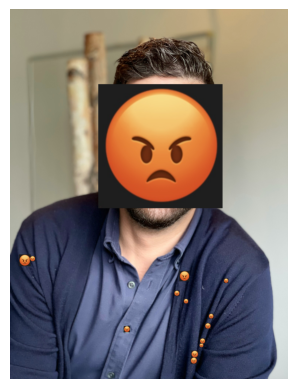

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the pre-trained model (replace 'your_model.h5' with the actual model path)
model = load_model('Model.h5')

# Define the class labels (replace with your actual classes)
classes = ['happy', 'sad', 'angry', 'surprised', 'neutral']  # Example classes

# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Read the image
img = cv2.imread('man-face.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray)

# Define a function to overlay emoji on the image
def plot_image(img, emoj, x, y, w, h):
    emoj = cv2.resize(emoj, (w, h))
    # Check if the emoji image has an alpha channel for transparency
    if emoj.shape[2] == 4:  # RGBA
        for i in range(h):
            for j in range(w):
                if emoj[i, j][3] != 0:  # Check if the pixel is not transparent
                    img[y + i, x + j] = emoj[i, j][:3]
    else:
        img[y:y+h, x:x+w] = emoj

# Iterate over the detected faces
for (x, y, w, h) in faces:
    # Adjust the bounding box and resize the face region
    face_region = gray[y:y+h, x:x+w]
    face_region_resized = cv2.resize(face_region, (48, 48))

    # Prepare the face region for prediction
    face_region_resized = np.expand_dims(face_region_resized, axis=-1)
    face_region_resized = np.expand_dims(face_region_resized, axis=0)

    # Make a prediction
    pred = model.predict(face_region_resized)
    idx = pred.argmax(axis=-1)[0]

    # Load the corresponding emoji
    emoji_path = f'/content/drive/MyDrive/Colab Notebooks/Emojify---Detect-emotion-from-human-face-ML-Project--main/emojis/{classes[idx]}.jpg'
    emoj = cv2.imread(emoji_path)

    # Check if the emoji image is loaded correctly
    if emoj is None:
        print(f"Failed to load emoji image: {emoji_path}")
        continue  # Skip this face if the emoji image is not found

    # Overlay the emoji on the original image
    plot_image(img, emoj, x, y, w, h)

# Display the final image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
classes[idx]